# Exploratory Data Analysis

## Import libraries

In [91]:
import pandas as pd

### Load data

In [41]:
df = pd.read_csv('Train.csv', sep=';')
df.head()

,name,condition,opinion,rate,rate1
0,Zegerid,GERD,"""Using it as a replacement for Nexium, since i...",10,high
1,Ethosuximide,Seizures,"""This medicine is very good at controlling me ...",10,high
2,Tri-Sprintec,Birth Control,"""I just started taking Tri Sprintec after my l...",9,high
3,Levaquin,Pneumonia,"""This medicine made me feel absolutely horribl...",5,medium
4,Methylphenidate,ADHD,"""I&#039;ve been taking Concerta since 2003. Fo...",9,high


In [42]:
len(df)

150000

In [43]:
df['opinion'].str.len().mean()

458.68765333333334

In [44]:
df['opinion'].str.len().max()

10745

In [45]:
df['opinion'].str.len().min()


3

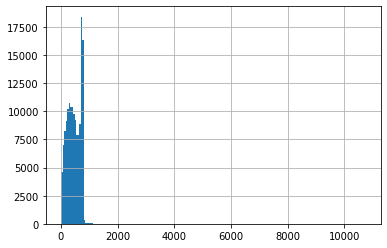

In [46]:
df['opinion'].str.len().hist(bins=200)

In [47]:
len(df[df['opinion'].str.len() < 1000])

149699

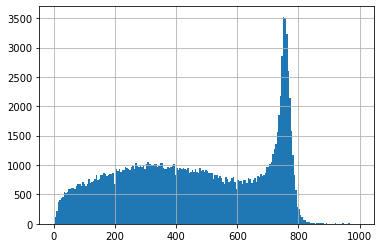

In [48]:
df[df['opinion'].str.len() < 1000]['opinion'].str.len().hist(bins=200)

In [49]:
df.groupby(by='rate').name.count()

rate
1     20156
2      6431
3      6056
4      4656
5      7463
6      5883
7      8801
8     17554
9     25527
10    47473
Name: name, dtype: int64

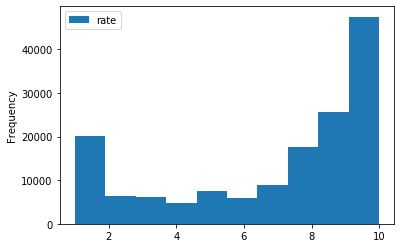

In [50]:
df.plot.hist(by='rate')


In [53]:
df['op_len'] = df['opinion'].str.len()

In [57]:
print(df.corr())
print(df[df['op_len'] < 1000 ].corr())

rate    op_len
rate    1.000000  0.021406
op_len  0.021406  1.000000
            rate    op_len
rate    1.000000  0.023162
op_len  0.023162  1.000000


In [58]:
df[df['op_len'] < 1000 ].corr().style.background_gradient(cmap='coolwarm')


,rate,op_len
rate,1.000000,0.023162
op_len,0.023162,1.000000


In [ ]:
df.groupby()

# Data cleaning

In [ ]:
from html import unescape

Remove html escaping

In [117]:
df.update(df[df['opinion'].str.contains('&')]['opinion'].apply(unescape))
df.opinion.head()

remove trailing "

In [120]:
df['opinion'] = df['opinion'].str[1:-1]
df.opinion.head()

0    Using it as a replacement for Nexium, since in...
1    This medicine is very good at controlling me s...
2    I just started taking Tri Sprintec after my la...
3    This medicine made me feel absolutely horrible...
4    I've been taking Concerta since 2003. For me i...
Name: opinion, dtype: object

# N-Grams

In [161]:
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression


In [133]:
df['bin_score'] = pd.to_numeric(df['rate']) > 5
train, test = train_test_split(df, test_size=0.2)

In [155]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['opinion'])
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [158]:
lr = LogisticRegression(solver='saga',        
                        multi_class='multinomial',
                        penalty='l1',
                        random_state=42)
lr.fit(X_train_tfidf, train['rate'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [159]:
X_test_counts = count_vect.transform(test['opinion'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [164]:
predicted = lr.predict(X_test_tfidf)

accuracy = np.sum(predicted == test['rate']) / predicted.shape[0]
print(accuracy)

0.4442333333333333


In [168]:
error = np.sum(np.abs(predicted - test['rate'])) / predicted.shape[0]
print(error)

1.6245666666666667


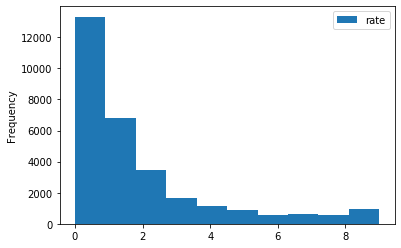

In [182]:
pd.DataFrame(data=np.abs(predicted - test['rate'])).plot.hist()